# Berlin Bicycle Data

## A Summary of what I have done in this file

1. Downloading the Data:

> Obtained an Excel file named raw_data_bicyle_volume.xlsx containing multiple sheets:

    > Standortdaten: Metadata about cycling stations (e.g., location, installation dates).
    > Yearly Sheets (2012–2023): Hourly cycling volume data for multiple stations.

2. Loading the Data:

> Loaded the Excel file using Python (pandas.ExcelFile), focusing on:

    > Standortdaten for station metadata.
    > Yearly sheets (Jahresdatei) for cycling volume data.

3. Processing Yearly Sheets:

> For each yearly sheet:

    > Extracted Timestamp and station identifiers (Zählstelle).
    > Reshaped data into a long format where each row represents a timestamp-station combination.

4. Handling Station Identifier Issues:

Identified and fixed two typographical errors in station identifiers (Zählstelle) between the yearly data and Standortdaten.
Corrected these errors manually to ensure consistency. 

5. Merging Data:

> Merged the processed yearly data with Standortdaten to enrich it with station metadata (e.g., coordinates, descriptions).
> Created a consolidated dataset containing cycling volumes, timestamps, station metadata, and location data.

6. Saving the Consolidated Dataset:

Saved the consolidated dataset as a CSV file named consolidated_cycling_data.csv for further analysis.

**Data Description – Bicycle Counting Stations Data**

The dataset used in this study consists of bicycle count records collected from long-term counting stations installed throughout Berlin. The data is publicly available and downloaded from the *Senate Department for the Environment, Mobility, Consumer, and Climate Protection Berlin (2025)*. The data comes from the counting stations, which use embedded electromagnetic sensors to detect passing bicycles. The city has installed these stations over several years, with counts available from 2012 to 2023.

The dataset is provided as an Excel file containing a metadata sheet and yearly sheets for each year from 2012 to 2023. The metadata sheet contains information on station attributes, including their names, locations, and installation years. The yearly sheets contain hourly bicycle counts for multiple stations. Some stations record traffic in both directions separately, while others aggregate counts into a single measure. For consistency, opposite-side stations were combined by summing their recorded values, reducing the number of distinct counting locations.

Occasionally, counting stations are out of service due to maintenance, construction, or sensor malfunctions, leading to missing observations. The rows with missing data for bicycle counts were excluded from the final dataset. Two typographical errors in station identifiers were also identified and corrected to maintain consistency across yearly records.

After data cleaning and preprocessing, the dataset consists of 1,275,653 observations with five variables: timestamp, station name, cycling volume, latitude, and longitude.

In [1]:
import openpyxl
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import folium
import seaborn as sns
import numpy as np
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from sklearn.preprocessing import StandardScaler

## Merging the Metadata with the Yearly Data Sheets

In [2]:
# Let's load the Excel file
file_path = "raw_data_bicycle_volume.xlsx"
excel_file = pd.ExcelFile(file_path)

In [3]:
# Now let's load the Standortdaten sheet
standortdaten_df = excel_file.parse("Standortdaten")

# And identify the yearly data sheets
yearly_sheets = [sheet for sheet in excel_file.sheet_names if "Jahresdatei" in sheet]

In [4]:
# Now let's initialize an empty DataFrame for combined data
combined_data = pd.DataFrame()

# And process each yearly sheet and merge with Standortdaten
for sheet in yearly_sheets:
    # Load the yearly data
    yearly_data = excel_file.parse(sheet)
    
    # Extract station identifiers from column names
    station_columns = yearly_data.columns[1:]  # Exclude the timestamp column
    extracted_stations = [col.split()[0] for col in station_columns]
    yearly_data.columns = ["Timestamp"] + extracted_stations
    
    # Reshape into long format
    yearly_data_long = pd.melt(
        yearly_data,
        id_vars=["Timestamp"],
        var_name="Zählstelle",
        value_name="Cycling Volume"
    )
    
    # Merge with Standortdaten
    yearly_data_merged = pd.merge(
        yearly_data_long,
        standortdaten_df,
        how="left",
        on="Zählstelle"
    )
    
    # Append the processed yearly data to the combined DataFrame
    combined_data = pd.concat([combined_data, yearly_data_merged], ignore_index=True)


In [5]:
# Step 6: Save the consolidated dataset
output_path = "consolidated_cycling_data_berlin.csv"
combined_data.to_csv(output_path, index=False)
print(f"Consolidated dataset saved to {output_path}")

Consolidated dataset saved to consolidated_cycling_data_berlin.csv


## Data Cleaning and Exploration

In [6]:
# Let's load the dataset
file_path = "consolidated_cycling_data_berlin.csv"
data = pd.read_csv(file_path)

In [7]:
# Let's check some basic information
print("Dataset Information:")
print(data.info())

print("\nSample Data:")
print(data.head())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3085366 entries, 0 to 3085365
Data columns (total 7 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Timestamp                     object 
 1   Zählstelle                    object 
 2   Cycling Volume                float64
 3   Beschreibung - Fahrtrichtung  object 
 4   Breitengrad                   float64
 5   Längengrad                    float64
 6   Installationsdatum            object 
dtypes: float64(3), object(4)
memory usage: 164.8+ MB
None

Sample Data:
             Timestamp   Zählstelle  Cycling Volume  \
0  2012-01-01 00:00:00  02-MI-JAN-N             NaN   
1  2012-01-01 01:00:00  02-MI-JAN-N             NaN   
2  2012-01-01 02:00:00  02-MI-JAN-N             NaN   
3  2012-01-01 03:00:00  02-MI-JAN-N             NaN   
4  2012-01-01 04:00:00  02-MI-JAN-N             NaN   

  Beschreibung - Fahrtrichtung  Breitengrad  Längengrad Installationsdatum  

In [8]:
# Now, let's chekc for missing values
missing_summary = data.isnull().sum()
print("\nMissing Values Summary:")
print(missing_summary)


Missing Values Summary:
Timestamp                             0
Zählstelle                            0
Cycling Volume                  1162139
Beschreibung - Fahrtrichtung          0
Breitengrad                           0
Längengrad                            0
Installationsdatum                    0
dtype: int64


In [9]:
# Percentage of missing values for better understanding
missing_percentage = (missing_summary / len(data)) * 100
print("\nPercentage of Missing Values:")
print(missing_percentage)


Percentage of Missing Values:
Timestamp                        0.000000
Zählstelle                       0.000000
Cycling Volume                  37.666163
Beschreibung - Fahrtrichtung     0.000000
Breitengrad                      0.000000
Längengrad                       0.000000
Installationsdatum               0.000000
dtype: float64


### Key Observations from the Data Exploration

1. A high percentage of Missing Values in Cycling Volume (37.67%):

    a. A significant portion of the target variable is missing.
   
    b. This needs careful attention since Cycling Volume is critical for forecasting. At the moment, I have decided to drop them.

3. Column Data Types:

    a. Timestamp and Installationsdatum are of object type and should be converted to datetime for time-series analysis.
   
    b. Zählstelle and Beschreibung - Fahrtrichtung are categorical and could be optimized using the category data type.

5. No Missing Values in Metadata:
Metadata columns (Beschreibung - Fahrtrichtung, Breitengrad, Längengrad, Installationsdatum) are complete, which is good.

### Data Cleaning

In [10]:
# Let's drop the missing values in Cycling Volume
data = data.dropna(subset=["Cycling Volume"])

In [11]:
# Now let's convert Timestamp and Installationsdatum to datetime
data["Timestamp"] = pd.to_datetime(data["Timestamp"], errors="coerce")

In [12]:
# Now, let's optimize the data types
# First, let's convert categorical columns to category
data["Beschreibung - Fahrtrichtung"] = data["Beschreibung - Fahrtrichtung"].astype("category")

# And, downcast the numerical columns
data["Cycling Volume"] = pd.to_numeric(data["Cycling Volume"], downcast="float")
data["Breitengrad"] = pd.to_numeric(data["Breitengrad"], downcast="float")
data["Längengrad"] = pd.to_numeric(data["Längengrad"], downcast="float")

In [14]:
# Let's change the name of the variables to english and to a more readable format
data.rename(
    columns={
        "Timestamp": "timestamp",
        "Cycling Volume": "cycling_volume",
        "Beschreibung - Fahrtrichtung": "station_name",
        "Breitengrad": "latitude",
        "Längengrad": "longitude",
    },
    inplace=True
)

# Let's also drop the variables which we won't need going forward
data = data.drop(columns=['Zählstelle', 'Installationsdatum'])
print(data.head())
print(data.info())

                 timestamp  cycling_volume    station_name   latitude  \
176880 2012-03-01 00:00:00            11.0  Schwedter Steg  52.549072   
176881 2012-03-01 01:00:00            10.0  Schwedter Steg  52.549072   
176882 2012-03-01 02:00:00             2.0  Schwedter Steg  52.549072   
176883 2012-03-01 03:00:00             2.0  Schwedter Steg  52.549072   
176884 2012-03-01 04:00:00             0.0  Schwedter Steg  52.549072   

        longitude  
176880  13.400367  
176881  13.400367  
176882  13.400367  
176883  13.400367  
176884  13.400367  
<class 'pandas.core.frame.DataFrame'>
Index: 1923227 entries, 176880 to 3085365
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   timestamp       datetime64[ns]
 1   cycling_volume  float32       
 2   station_name    category      
 3   latitude        float32       
 4   longitude       float32       
dtypes: category(1), datetime64[ns](1), float32(3)
memory usage: 53.2 MB
None

In [16]:
# And let's save the cleaned dataset
clean_file_path = "clean_cycling_data_berlin_27012025.csv"
data.to_csv(clean_file_path, index=False)
print(f"Cleaned dataset saved to {clean_file_path}")

Cleaned dataset saved to clean_cycling_data_berlin_27012025.csv


### Combining Opposite-Side Stations

In this step, we consolidate the bicycle counter data by aggregating cycling volumes from stations that are in close proximity, effectively merging stations located on opposite sides of the same street. Instead of manually identifying opposite-side pairs using base names and directional suffixes (e.g., Nord/Süd, Ost/West), we employ spatial clustering to group stations within a 100-meter radius. This ensures that stations measuring the same flow of bicycle traffic, regardless of direction, are treated as a single entity. The clustering process assigns a unified station name, and the latitude and longitude of grouped stations are updated to reflect the mean location within the cluster.

For clustered stations, cycling volumes are summed per timestamp, ensuring that total bicycle activity at a given site is captured accurately. Additionally, station names are standardized, eliminating directional suffixes where applicable to maintain clarity in the dataset. For example, "Jannowitzbrücke Nord" and "Jannowitzbrücke Süd" are automatically merged into "Jannowitzbrücke," their cycling counts summed, and their location adjusted to a single representative coordinate. Standalone stations that do not belong to any cluster remain unchanged, preserving their original names and locations.

In [2]:
# Let's load the dataset
file_path = "clean_cycling_data_berlin_27012025.csv"
data = pd.read_csv(file_path)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1923227 entries, 0 to 1923226
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   timestamp       object 
 1   cycling_volume  float64
 2   station_name    object 
 3   latitude        float64
 4   longitude       float64
dtypes: float64(3), object(2)
memory usage: 73.4+ MB


In [4]:
# Let's create a dictionary for opposite pairs to rename them to their base names
rename_opposite_pairs = {
    "Jannowitzbrücke Nord": "Jannowitzbrücke",
    "Jannowitzbrücke Süd": "Jannowitzbrücke",
    "Yorckstraße Ost": "Yorckstraße",
    "Yorkstraße West": "Yorckstraße",
    "Invalidenstraße Ost": "Invalidenstraße",
    "Invalidenstraße West": "Invalidenstraße",
    "Oberbaumbrücke Ost": "Oberbaumbrücke",
    "Oberbaumbrücke West": "Oberbaumbrücke",
    "Berliner Straße Nord": "Berliner Straße",
    "Berliner Straße Süd": "Berliner Straße",
    "Klosterstraße Nord": "Klosterstraße",
    "Klosterstraße Süd": "Klosterstraße",
    "Breitenbachplatz Ost": "Breitenbachplatz",
    "Breitenbachplatz West": "Breitenbachplatz",
    "Mariendorfer Damm Nord": "Mariendorfer Damm",
    "Mariendorfer Damm Süd": "Mariendorfer Damm",
    "Frankfurter Allee Ost": "Frankfurter Allee",
    "Frankfurter Allee West": "Frankfurter Allee",
    "Straße des 17. Juni West": "Straße des 17. Juni",
    "Straße des 17. Juni Ost": "Straße des 17. Juni",
    "Nonnendammallee Ost": "Nonnendammallee",
    "Nonnendammallee West": "Nonnendammallee"
}

# Let's rename the station names in the data based on the dictionary
data["station_name"] = data["station_name"].replace(rename_opposite_pairs)

In [5]:
# Now, let's cxtract unique stations for clustering
unique_stations = data[["station_name", "latitude", "longitude"]].drop_duplicates()

In [6]:
# And, convert lat/lon to numpy array
coords = unique_stations[["latitude", "longitude"]].to_numpy()

# Use DBSCAN to cluster stations that are very close together (~50 meters)
kms_per_radian = 6371.0088
epsilon = 0.1 / kms_per_radian  # 50 meters converted to radians
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

In [7]:
# Let's check if clustering works properly
if len(coords) > 0:
    cluster_labels = db.fit_predict(np.radians(coords))
    unique_stations["cluster"] = cluster_labels
else:
    unique_stations["cluster"] = -1  # Assign a dummy cluster if no clustering happens

# **Verify if the cluster column exists**
if "cluster" not in unique_stations.columns:
    raise ValueError("DBSCAN did not assign cluster labels correctly!")

In [8]:
# And, compute mean latitude and longitude for each cluster and keep a representative station name
clustered_stations = unique_stations.groupby("cluster").agg({
    "station_name": "first",  # Keep one station name from the cluster
    "latitude": "mean",
    "longitude": "mean"
}).reset_index()

In [9]:
# Let's also ensure we have cluster labels before merging
if "cluster" in clustered_stations.columns:
    # Merge back with original data to map clusters
    data = data.merge(unique_stations, on=["station_name", "latitude", "longitude"], how="left")

    # Now replace station names with clustered names
    data = data.merge(clustered_stations, on="cluster", suffixes=("", "_clustered"))

    # Drop old columns and keep only clustered station names
    data.drop(columns=["station_name", "latitude", "longitude", "cluster"], inplace=True)
    data.rename(columns={"station_name_clustered": "station_name", "latitude_clustered": "latitude", "longitude_clustered": "longitude"}, inplace=True)
else:
    raise ValueError("Cluster column is missing after DBSCAN processing!")

In [10]:
# Now finally let's sum cycling volumes for merged stations per timestamp
data = data.groupby(["timestamp", "station_name", "latitude", "longitude"], as_index=False).agg({
    "cycling_volume": "sum"
})

In [11]:
# Let's check the dataset info to see the changes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275653 entries, 0 to 1275652
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   timestamp       1275653 non-null  object 
 1   station_name    1275653 non-null  object 
 2   latitude        1275653 non-null  float64
 3   longitude       1275653 non-null  float64
 4   cycling_volume  1275653 non-null  float64
dtypes: float64(3), object(2)
memory usage: 48.7+ MB


In [12]:
# Let's check if all the unique stations have unique lat and long
data[["station_name", "latitude", "longitude"]].drop_duplicates()

,station_name,latitude,longitude
0,Schwedter Steg,52.549072,13.400367
27022,Jannowitzbrücke,52.513936,13.417722
27023,Prinzregentenstraße,52.488136,13.333120
27025,Yorckstraße,52.492110,13.373341
29903,Markstraße,52.558190,13.364944
29904,Monumentenstraße,52.488117,13.369785
34366,Invalidenstraße,52.527431,13.372561
34370,Oberbaumbrücke,52.501236,13.444964
34371,Paul-und-Paula-Uferweg,52.500324,13.474302
40846,Alberichstraße,52.492535,13.558493


In [13]:
# Let's save the combined dataset to a CSV file
data.to_csv("cycling_data_berlin_28012025.csv", index=False)

print("Dataset saved successfully.")

Dataset saved successfully.


## Some Initial Dataset Checks

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275653 entries, 0 to 1275652
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   timestamp       1275653 non-null  object 
 1   station_name    1275653 non-null  object 
 2   latitude        1275653 non-null  float64
 3   longitude       1275653 non-null  float64
 4   cycling_volume  1275653 non-null  float64
dtypes: float64(3), object(2)
memory usage: 48.7+ MB


In [15]:
map_center = [data['latitude'].mean(), data['longitude'].mean()]
bike_map = folium.Map(location=map_center, zoom_start=12)

for _, row in data.drop_duplicates(subset=['station_name']).iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Name: {row['station_name']}",
        tooltip=row['station_name']
    ).add_to(bike_map)

bike_map

In [16]:
data['station_name'].nunique()

22

In [17]:
unique_names = data['station_name'].unique()
unique_names_list = unique_names.tolist()
print(unique_names_list)

['Schwedter Steg', 'Jannowitzbrücke', 'Prinzregentenstraße', 'Yorckstraße', 'Markstraße', 'Monumentenstraße', 'Invalidenstraße', 'Oberbaumbrücke', 'Paul-und-Paula-Uferweg', 'Alberichstraße', 'Berliner Straße', 'Breitenbachplatz', 'Kaisersteg', 'Klosterstraße', 'Mariendorfer Damm', 'Maybachufer', 'Frankfurter Allee', 'Straße des 17. Juni', 'Karl-Marx-Allee', 'Senefelder Platz Nord', 'Nordufer', 'Nonnendammallee']


In [18]:
# Let's check the total counts by location
location_counts = data.groupby(['station_name'])['cycling_volume'].sum().reset_index()
location_counts = location_counts.sort_values(by='cycling_volume', ascending=False)

# Top 10 busiest locations
print("Top 10 busiest locations:")
print(location_counts.head(10))

# Least busy locations
print("Top 10 least busy locations:")
print(location_counts.tail(10))

Top 10 busiest locations:
              station_name  cycling_volume
5          Jannowitzbrücke      24693214.0
15          Oberbaumbrücke      20202155.0
1          Berliner Straße      16044072.0
21             Yorckstraße      15618292.0
11             Maybachufer      13408552.0
4          Invalidenstraße      11991768.0
12        Monumentenstraße      11526126.0
3        Frankfurter Allee      11157069.0
18          Schwedter Steg       9893790.0
16  Paul-und-Paula-Uferweg       9219299.0
Top 10 least busy locations:
             station_name  cycling_volume
8           Klosterstraße       4300356.0
10             Markstraße       4001898.0
6              Kaisersteg       3474502.0
9       Mariendorfer Damm       3170200.0
20    Straße des 17. Juni       2374363.0
0          Alberichstraße       1574370.0
19  Senefelder Platz Nord       1325624.0
7         Karl-Marx-Allee       1024519.0
14               Nordufer         48811.0
13        Nonnendammallee         13458.0


In [19]:
# Calculate the first and last count timestamps for each location
location_time_stats = data.groupby(['station_name']).agg(
    first_count=('timestamp', 'min'),  # Earliest count
    last_count=('timestamp', 'max')   # Latest count
).reset_index()

# Display the result directly
print(location_time_stats)

              station_name          first_count           last_count
0           Alberichstraße  2015-07-01 00:00:00  2023-12-31 23:00:00
1          Berliner Straße  2016-05-01 00:00:00  2023-12-31 23:00:00
2         Breitenbachplatz  2016-05-01 00:00:00  2023-12-31 23:00:00
3        Frankfurter Allee  2016-06-01 00:00:00  2023-12-31 23:00:00
4          Invalidenstraße  2015-06-01 00:00:00  2023-12-31 23:00:00
5          Jannowitzbrücke  2015-04-01 00:00:00  2023-12-31 23:00:00
6               Kaisersteg  2016-05-01 00:00:00  2023-12-31 23:00:00
7          Karl-Marx-Allee  2021-12-16 16:00:00  2023-12-31 23:00:00
8            Klosterstraße  2016-05-01 00:00:00  2023-12-31 23:00:00
9        Mariendorfer Damm  2016-05-01 00:00:00  2023-12-31 23:00:00
10              Markstraße  2015-05-01 00:00:00  2023-12-31 23:00:00
11             Maybachufer  2016-05-01 00:00:00  2023-12-31 23:00:00
12        Monumentenstraße  2015-05-01 00:00:00  2023-12-31 23:00:00
13         Nonnendammallee  2023-1

In [20]:
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')
data['date'] = data['timestamp'].dt.date
coverage = data.groupby(['station_name'])['date'].nunique().reset_index(name='days_with_data')
print(coverage)

              station_name  days_with_data
0           Alberichstraße            3106
1          Berliner Straße            2801
2         Breitenbachplatz            2801
3        Frankfurter Allee            2770
4          Invalidenstraße            3136
5          Jannowitzbrücke            3197
6               Kaisersteg            2793
7          Karl-Marx-Allee             381
8            Klosterstraße            2801
9        Mariendorfer Damm            2801
10              Markstraße            3167
11             Maybachufer            2801
12        Monumentenstraße            3167
13         Nonnendammallee              40
14                Nordufer              77
15          Oberbaumbrücke            2611
16  Paul-und-Paula-Uferweg            3115
17     Prinzregentenstraße            3197
18          Schwedter Steg            4323
19   Senefelder Platz Nord             365
20     Straße des 17. Juni             523
21             Yorckstraße            3197


In [21]:
station_volume = data.groupby("station_name")["cycling_volume"].agg(
    total_volume='sum',
    avg_volume='mean',
    max_volume='max',
    min_volume='min'
).reset_index()

station_volume = station_volume.sort_values(by='total_volume', ascending=False)

print(station_volume)

              station_name  total_volume  avg_volume  max_volume  min_volume
5          Jannowitzbrücke    24693214.0  321.857301      2602.0         0.0
15          Oberbaumbrücke    20202155.0  322.486312      2140.0         0.0
1          Berliner Straße    16044072.0  238.690688      1272.0         0.0
21             Yorckstraße    15618292.0  203.569928      2169.0         0.0
11             Maybachufer    13408552.0  199.481560      1341.0         0.0
4          Invalidenstraße    11991768.0  159.339986      1016.0         0.0
12        Monumentenstraße    11526126.0  151.713451      2023.0         0.0
3        Frankfurter Allee    11157069.0  167.841096       924.0         0.0
18          Schwedter Steg     9893790.0   95.367347       780.0         0.0
16  Paul-und-Paula-Uferweg     9219299.0  123.652713       952.0         0.0
2         Breitenbachplatz     6651867.0   98.961081      1424.0         0.0
17     Prinzregentenstraße     4422564.0   57.656037       812.0         0.0

## Exploratory Data Analysis

In [22]:
# Let's do the overview of the dataset
# Let's display the basic statistics
print("Dataset Overview:")
print(data.describe(include="all"))

# And check the time range
time_range = (data["timestamp"].min(), data["timestamp"].max())
print(f"\nTime range in data: {time_range}")

Dataset Overview:
                            timestamp    station_name      latitude  \
count                         1275653         1275653  1.275653e+06   
unique                            NaN              22           NaN   
top                               NaN  Schwedter Steg           NaN   
freq                              NaN          103744           NaN   
mean    2019-10-20 17:32:16.183897856             NaN  5.250664e+01   
min               2012-03-01 00:00:00             NaN  5.243830e+01   
25%               2017-09-17 12:00:00             NaN  5.248814e+01   
50%               2019-11-08 06:00:00             NaN  5.250032e+01   
75%               2022-01-12 05:00:00             NaN  5.253138e+01   
max               2023-12-31 23:00:00             NaN  5.256687e+01   
std                               NaN             NaN  3.330718e-02   

           longitude  cycling_volume        date  
count   1.275653e+06    1.275653e+06     1275653  
unique           NaN       

In [23]:
data.isnull().sum()

timestamp         0
station_name      0
latitude          0
longitude         0
cycling_volume    0
date              0
dtype: int64

#### Temporal Analysis

Let's analyze cycling volumes over time to identify trends and seasonality

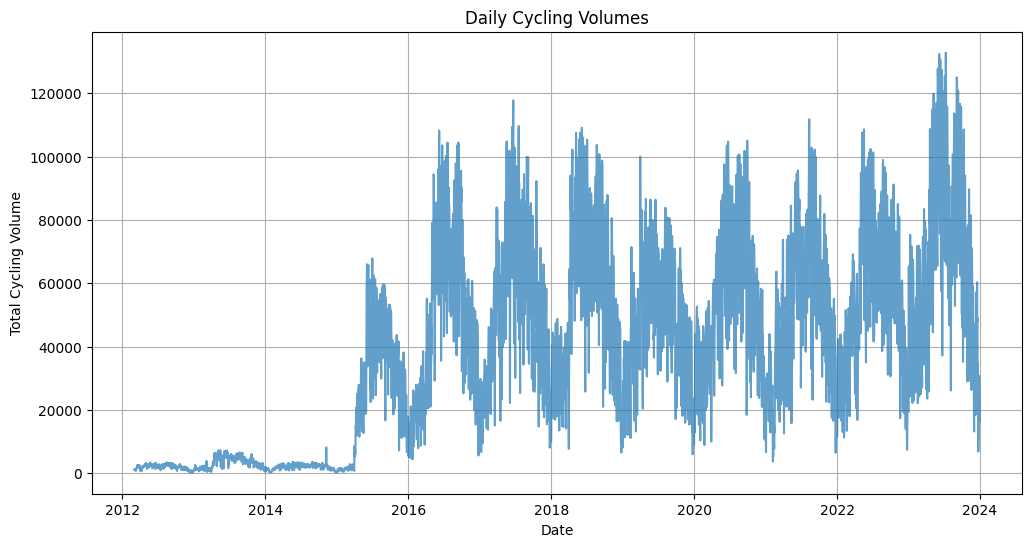

In [24]:
# Let's check the daily trends

data.set_index("timestamp", inplace=True)

# First let's resample to daily cycling volumes
daily_data = data["cycling_volume"].resample("D").sum()

# Now, let's plot and check the daily trends
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data, alpha=0.7)
plt.title("Daily Cycling Volumes")
plt.xlabel("Date")
plt.ylabel("Total Cycling Volume")
plt.grid(True)
plt.show()

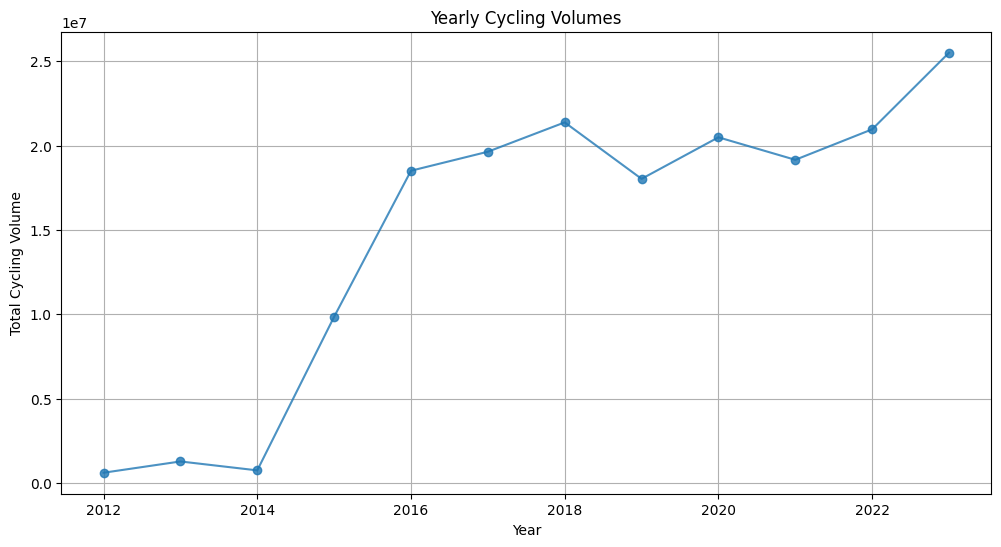

In [25]:
# Now let's check seasonality and yealry trends
# Extract year from Timestamp
data["year"] = data.index.year

# Group by year to calculate yearly totals
yearly_data = data.groupby("year")["cycling_volume"].sum()

plt.figure(figsize=(12, 6))
plt.plot(yearly_data.index, yearly_data, marker="o", alpha=0.8)
plt.title("Yearly Cycling Volumes")
plt.xlabel("Year")
plt.ylabel("Total Cycling Volume")
plt.grid(True)
plt.show()

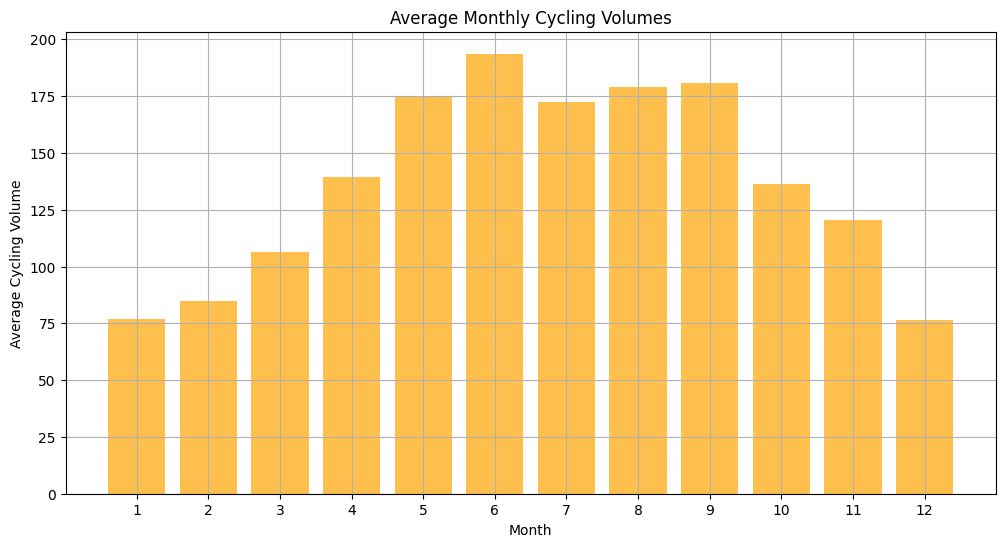

In [26]:
# Now let's analyse monthly patterns to identify the seasonality in cycling volumes
# Extract month from Timestamp
data["month"] = data.index.month

# Group by month to calculate average monthly totals
monthly_data = data.groupby("month")["cycling_volume"].mean()

# Plot monthly trends
plt.figure(figsize=(12, 6))
plt.bar(monthly_data.index, monthly_data, alpha=0.7, color="orange")
plt.title("Average Monthly Cycling Volumes")
plt.xlabel("Month")
plt.ylabel("Average Cycling Volume")
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

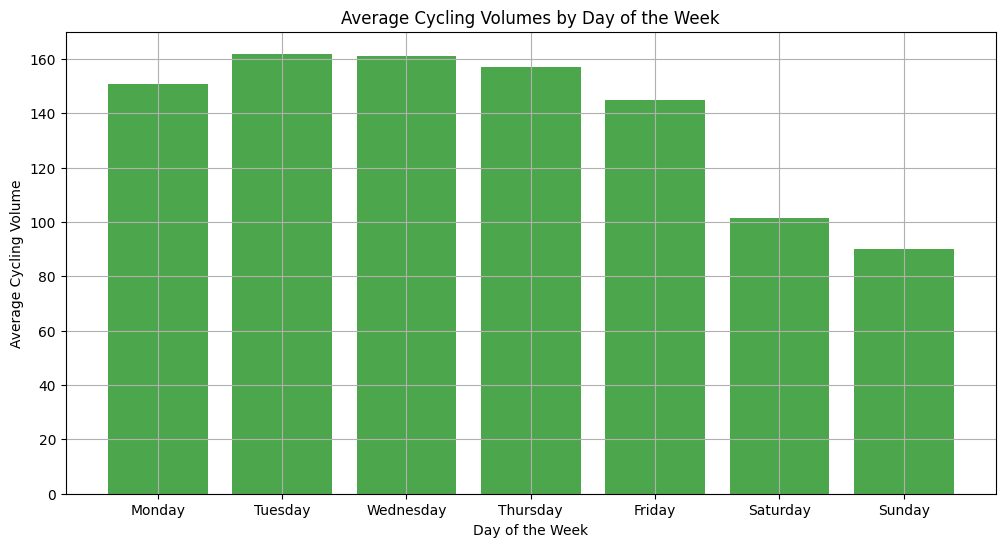

In [27]:
# Now let's analyse average cycling volumes by day of the week
# Extract day of the week from Timestamp
data["day_of_week"] = data.index.dayofweek

# Map day numbers to names for better readability
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data["day_of_week_name"] = data["day_of_week"].map(dict(enumerate(day_names)))

# Group by day of the week
weekly_data = data.groupby("day_of_week_name")["cycling_volume"].mean()

# Ensure days are ordered correctly
weekly_data = weekly_data.reindex(day_names)

# Plot weekly trends
plt.figure(figsize=(12, 6))
plt.bar(weekly_data.index, weekly_data, alpha=0.7, color="green")
plt.title("Average Cycling Volumes by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Cycling Volume")
plt.grid(True)
plt.show()

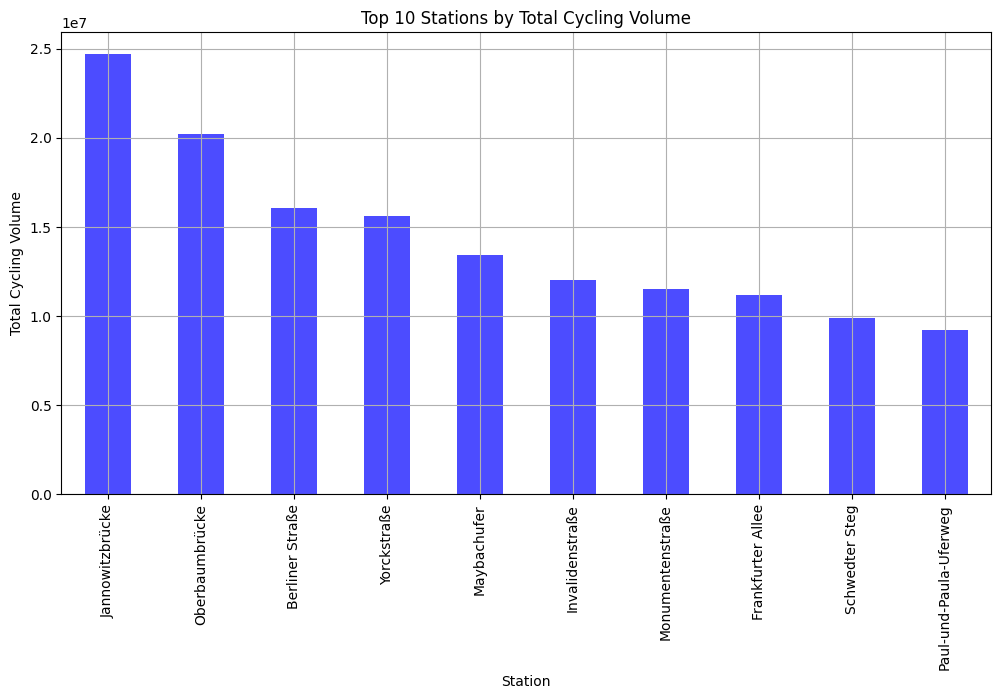

In [28]:
# Now let's analyse the total and average cycling volumes by station
# Group by station to calculate total volumes
station_totals = data.groupby("station_name")["cycling_volume"].sum().sort_values(ascending=False)

# Plot top 10 stations
plt.figure(figsize=(12, 6))
station_totals.head(10).plot(kind="bar", color="blue", alpha=0.7)
plt.title("Top 10 Stations by Total Cycling Volume")
plt.xlabel("Station")
plt.ylabel("Total Cycling Volume")
plt.grid(True)
plt.show()

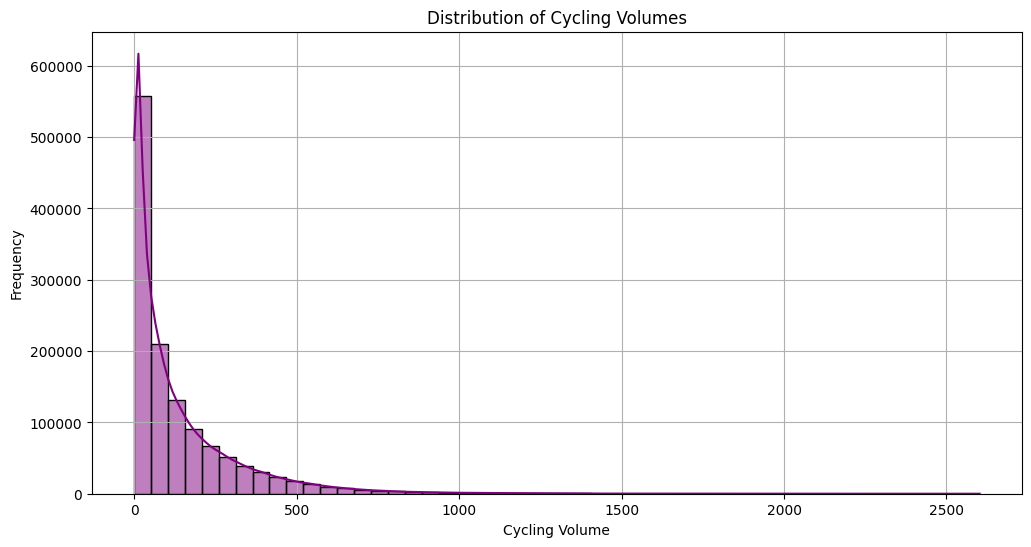

In [29]:
# Now let's visualise the distribution of cycling volumes
# Plot the distribution of cycling volumes
plt.figure(figsize=(12, 6))
sns.histplot(data["cycling_volume"], bins=50, kde=True, color="purple")
plt.title("Distribution of Cycling Volumes")
plt.xlabel("Cycling Volume")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

## Final Cleaning of the Dataset

In [3]:
# Let's load the dataset first 
data = pd.read_csv("cycling_data_berlin_28012025.csv")

In [4]:
# Some initial datachecks
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275653 entries, 0 to 1275652
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   timestamp       1275653 non-null  object 
 1   station_name    1275653 non-null  object 
 2   latitude        1275653 non-null  float64
 3   longitude       1275653 non-null  float64
 4   cycling_volume  1275653 non-null  float64
dtypes: float64(3), object(2)
memory usage: 48.7+ MB


In [5]:
data.head()

,timestamp,station_name,latitude,longitude,cycling_volume
0,2012-03-01 00:00:00,Schwedter Steg,52.549072,13.400367,11.0
1,2012-03-01 01:00:00,Schwedter Steg,52.549072,13.400367,10.0
2,2012-03-01 02:00:00,Schwedter Steg,52.549072,13.400367,2.0
3,2012-03-01 03:00:00,Schwedter Steg,52.549072,13.400367,2.0
4,2012-03-01 04:00:00,Schwedter Steg,52.549072,13.400367,0.0


In [6]:
# Now, let's convert 'timestamp' column to datetime format
data["timestamp"] = pd.to_datetime(data["timestamp"])

# And, filter data from 01/01/2015 onwards
data = data[data["timestamp"] >= "2015-01-01"]

In [7]:
# Now, let's drop data related to specific stations
stations_to_remove = ["Nonnendammallee", "Nordufer"]
data = data[~data["station_name"].isin(stations_to_remove)]

In [8]:
# And, save the cleaned dataset to a new CSV file
data.to_csv("cycling_data_berlin_07032025.csv", index=False)

print("Filtered dataset saved as 'cycling_data_berlin_07032025.csv'.")

Filtered dataset saved as 'cycling_data_berlin_07032025.csv'.


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1248009 entries, 24862 to 1275652
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   timestamp       1248009 non-null  datetime64[ns]
 1   station_name    1248009 non-null  object        
 2   latitude        1248009 non-null  float64       
 3   longitude       1248009 non-null  float64       
 4   cycling_volume  1248009 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 57.1+ MB


In [10]:
# Calculate the first and last count timestamps for each location
location_time_stats = data.groupby(['station_name']).agg(
    first_count=('timestamp', 'min'),  # Earliest count
    last_count=('timestamp', 'max')   # Latest count
).reset_index()

# Display the result directly
print(location_time_stats)

              station_name         first_count          last_count
0           Alberichstraße 2015-07-01 00:00:00 2023-12-31 23:00:00
1          Berliner Straße 2016-05-01 00:00:00 2023-12-31 23:00:00
2         Breitenbachplatz 2016-05-01 00:00:00 2023-12-31 23:00:00
3        Frankfurter Allee 2016-06-01 00:00:00 2023-12-31 23:00:00
4          Invalidenstraße 2015-06-01 00:00:00 2023-12-31 23:00:00
5          Jannowitzbrücke 2015-04-01 00:00:00 2023-12-31 23:00:00
6               Kaisersteg 2016-05-01 00:00:00 2023-12-31 23:00:00
7          Karl-Marx-Allee 2021-12-16 16:00:00 2023-12-31 23:00:00
8            Klosterstraße 2016-05-01 00:00:00 2023-12-31 23:00:00
9        Mariendorfer Damm 2016-05-01 00:00:00 2023-12-31 23:00:00
10              Markstraße 2015-05-01 00:00:00 2023-12-31 23:00:00
11             Maybachufer 2016-05-01 00:00:00 2023-12-31 23:00:00
12        Monumentenstraße 2015-05-01 00:00:00 2023-12-31 23:00:00
13          Oberbaumbrücke 2015-06-01 00:00:00 2023-12-31 23:0

In [11]:
data['date'] = data['timestamp'].dt.date
coverage = data.groupby(['station_name'])['date'].nunique().reset_index(name='days_with_data')
print(coverage)

              station_name  days_with_data
0           Alberichstraße            3106
1          Berliner Straße            2801
2         Breitenbachplatz            2801
3        Frankfurter Allee            2770
4          Invalidenstraße            3136
5          Jannowitzbrücke            3197
6               Kaisersteg            2793
7          Karl-Marx-Allee             381
8            Klosterstraße            2801
9        Mariendorfer Damm            2801
10              Markstraße            3167
11             Maybachufer            2801
12        Monumentenstraße            3167
13          Oberbaumbrücke            2611
14  Paul-und-Paula-Uferweg            3115
15     Prinzregentenstraße            3197
16          Schwedter Steg            3287
17   Senefelder Platz Nord             365
18     Straße des 17. Juni             523
19             Yorckstraße            3197


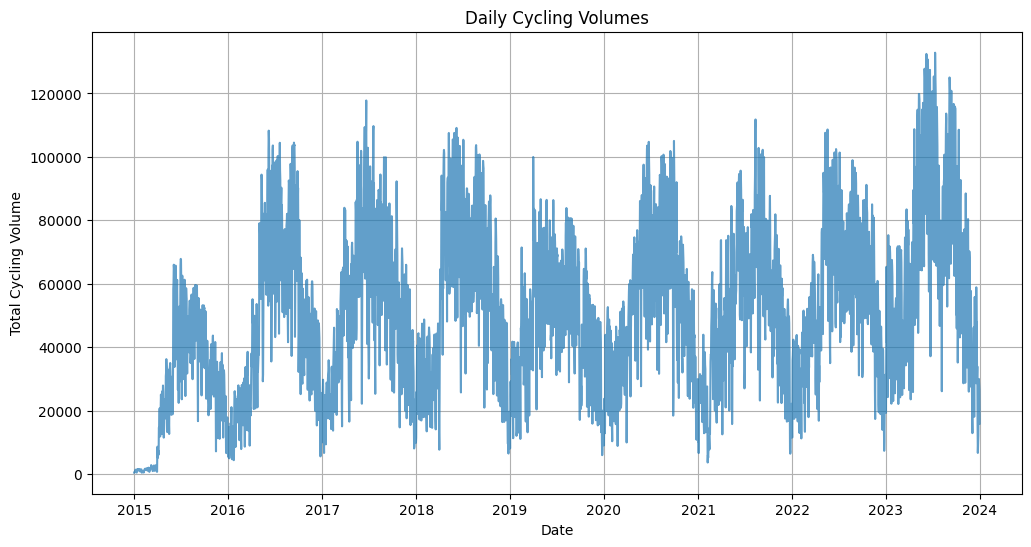

In [12]:
# Let's check the daily trends
data.set_index("timestamp", inplace=True)

# First let's resample to daily cycling volumes
daily_data = data["cycling_volume"].resample("D").sum()

# Now, let's plot and check the daily trends
plt.figure(figsize=(12, 6))
plt.plot(daily_data.index, daily_data, alpha=0.7)
plt.title("Daily Cycling Volumes")
plt.xlabel("Date")
plt.ylabel("Total Cycling Volume")
plt.grid(True)
plt.show()

## One Last Cleaning of the Cycle Dataset - Hourly Data to Daily Aggregation

In [2]:
# Let's load the last clean dataset
data = pd.read_csv('cycling_data_berlin_07032025.csv', parse_dates=['timestamp'])

In [3]:
# Let's make sure the timestamp is in the datetime format
data['date'] = data['timestamp'].dt.date

# Aggregate daily cycling volume per station
data = data.groupby(['station_name', 'date', 'latitude', 'longitude'])['cycling_volume'].sum().reset_index()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52017 entries, 0 to 52016
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   station_name    52017 non-null  object 
 1   date            52017 non-null  object 
 2   latitude        52017 non-null  float64
 3   longitude       52017 non-null  float64
 4   cycling_volume  52017 non-null  float64
dtypes: float64(3), object(2)
memory usage: 2.0+ MB


In [5]:
data.head()

,station_name,date,latitude,longitude,cycling_volume
0,Alberichstraße,2015-07-01,52.492535,13.558493,990.0
1,Alberichstraße,2015-07-02,52.492535,13.558493,1054.0
2,Alberichstraße,2015-07-03,52.492535,13.558493,855.0
3,Alberichstraße,2015-07-04,52.492535,13.558493,580.0
4,Alberichstraße,2015-07-05,52.492535,13.558493,352.0


In [6]:
# And, save the cleaned dataset to a new CSV file
data.to_csv("daily_cycling_data_berlin_12032025.csv", index=False)

print("Daily aggregated dataset saved as 'daily_cycling_data_berlin_12032025.csv'.")

Daily aggregated dataset saved as 'daily_cycling_data_berlin_12032025.csv'.


## Some Extra EDA

In [2]:
data = pd.read_csv("cycling_data_berlin_07032025.csv")

In [3]:
data.head()

,timestamp,station_name,latitude,longitude,cycling_volume
0,2015-01-01 00:00:00,Schwedter Steg,52.549072,13.400367,8.0
1,2015-01-01 01:00:00,Schwedter Steg,52.549072,13.400367,10.0
2,2015-01-01 02:00:00,Schwedter Steg,52.549072,13.400367,8.0
3,2015-01-01 03:00:00,Schwedter Steg,52.549072,13.400367,6.0
4,2015-01-01 04:00:00,Schwedter Steg,52.549072,13.400367,6.0


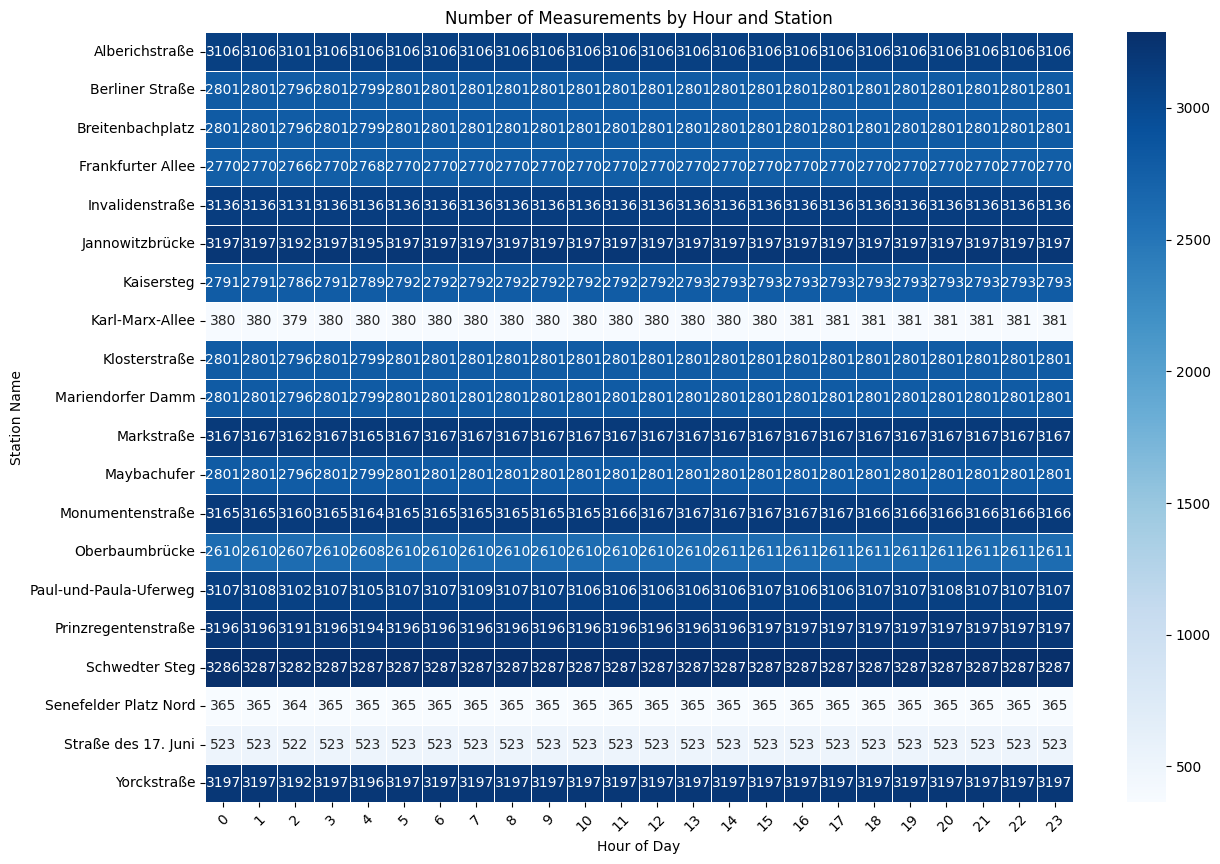

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already loaded your dataset into a DataFrame `df`

# Step 1: Extract the hour from the timestamp
data['hour'] = data['timestamp'].dt.hour

# Step 2: Group by station_name and hour, then count the measurements
data_grouped = data.groupby(['station_name', 'hour']).size().unstack(fill_value=0)

# Step 3: Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(data_grouped, cmap='Blues', annot=True, fmt='d', linewidths=0.5)

# Customizing the plot
plt.title('Number of Measurements by Hour and Station')
plt.xlabel('Hour of Day')
plt.ylabel('Station Name')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()
